# Tidal Heating and Torque versus Semi-major Axis
An example of using TidalPy OOP


In [1]:
# Setup Jupyter environment and load in useful packages 
%matplotlib inline 
import copy

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Delete me!
try:
    import TidalPy
except ModuleNotFoundError:
    import sys, os
    cwd = os.getcwd()
    tpy = os.path.join(cwd, os.pardir)
    if tpy not in sys.path:
        sys.path.append(tpy)
        

In [3]:
# Import TidalPy and build our planets
import TidalPy
from TidalPy.utilities.conversions import days2rads, orbital_motion2semi_a, sec2myr
from TidalPy.utilities.numpy_help import neg_array_for_log_plot


planet = TidalPy.build_planet('charon', force_build=True)
host = TidalPy.build_planet('pluto', force_build=True)
star = TidalPy.build_planet('sol', force_build=True)

# planet.paint(auto_show=True)
# host.paint(auto_show=True)

Iteration 1 maximum relative pressure error: 8.1e-01
Iteration 2 maximum relative pressure error: 1.8e-03
Iteration 3 maximum relative pressure error: 4.6e-06
Iteration 1 maximum relative pressure error: 1.6e-01
Iteration 2 maximum relative pressure error: 3.5e-03
Iteration 3 maximum relative pressure error: 3.5e-05
Iteration 4 maximum relative pressure error: 3.2e-07


In [44]:
# Inputs
modern_semi_major_axis = np.asarray([1.9591e7])
eccen = np.asarray([0.2])
inclin = np.asarray([5.0])
spin_frequency_host = np.asarray(days2rads(6.3872304))
spin_frequency_planet = np.asarray(days2rads(6.3872304))
spin_sync_host_semi_a_au = orbital_motion2semi_a(spin_frequency_host, host.mass, planet.mass) / modern_semi_major_axis
spin_sync_planet_semi_a_au = orbital_motion2semi_a(spin_frequency_planet, host.mass, planet.mass) / modern_semi_major_axis

# For comparison purposes, set the tidal scale = 1
planet.core.tidal_scale = 1.
host.core.tidal_scale = 1.

# Domain of study
semi_major_axis_scale = np.linspace(.2, 2.5, 1000)
# Make sure that the semi-major axis actually has the resonances
resonances = np.asarray(
        [spin_frequency_host, 2. * spin_frequency_host, spin_frequency_host / 2., (2 / 3) * spin_frequency_host,
         (3 / 2) * spin_frequency_host,
         spin_frequency_planet, 2. * spin_frequency_planet, spin_frequency_planet / 2., (2 / 3) * spin_frequency_planet,
         (3 / 2) * spin_frequency_planet])
resonances = orbital_motion2semi_a(resonances, host.mass, planet.mass) / modern_semi_major_axis
semi_major_axis_scale = np.concatenate((semi_major_axis_scale, resonances))
semi_major_axis_scale = np.sort(semi_major_axis_scale)
semi_major_axis = semi_major_axis_scale * modern_semi_major_axis

# Setup Material Properties
planet.mantle.temperature = 250.
planet.core.set_strength(viscosity=1.e20, shear_modulus=5.e10)
host.mantle.temperature = 250.
host.core.set_strength(viscosity=1.e20, shear_modulus=5.e10)

# Initialize Spin
planet.spin_freq = spin_frequency_planet.copy() * np.ones_like(semi_major_axis)
host.spin_freq = spin_frequency_host.copy() * np.ones_like(semi_major_axis)

In [45]:
# Make copies of planet with different rheologies
rheo_data = [('Maxwell', 'g'), ('Fixed Q=10', 'y'), ('Andrade', 'b')]

planet_andrade = copy.deepcopy(planet)
planet_andrade.config['layers']['Core']['rheology'] = {'compliance_model': 'Andrade'}
planet_andrade.reinit(update_spin=False)

host_andrade = copy.deepcopy(host)
host_andrade.config['layers']['Core']['rheology'] = {'compliance_model': 'Andrade'}
host_andrade.reinit(update_spin=False)

planet_fq = copy.deepcopy(planet)
planet_fq.config['quality_factor'] = 10.
planet_fq.config['layers']['Core']['rheology'] = {'compliance_model': 'Fixed_Q'}
planet_fq.reinit(update_spin=False)

host_fq = copy.deepcopy(host)
host_fq.config['quality_factor'] = 10.
host_fq.config['layers']['Core']['rheology'] = {'compliance_model': 'Fixed_Q'}
host_fq.reinit(update_spin=False)

planet_byrheo = {'Maxwell'   : copy.deepcopy(planet),
                 'Fixed Q=10': planet_fq,
                 'Andrade'   : planet_andrade
                 }
host_byrheo = {'Maxwell'   : copy.deepcopy(host),
               'Fixed Q=10': host_fq,
               'Andrade'   : host_andrade
               }

In [46]:
# Initialize Orbit
orbits_byrheo = {}
for rheo_name, planet_ in planet_byrheo.items():
    host_ = host_byrheo[rheo_name]

    orbit = TidalPy.Orbit(star, host_, planet_, duel_dissipation=True, time_study=True)
    orbit.set_orbit(planet_, semi_major_axis=semi_major_axis, eccentricity=eccen, inclination=inclin,
                    inclination_in_deg=True)
    orbits_byrheo[rheo_name] = orbit

## Plot Set 1


Plot Set 1 - Individual Evolution
Light colors in the plots indicate negative values.


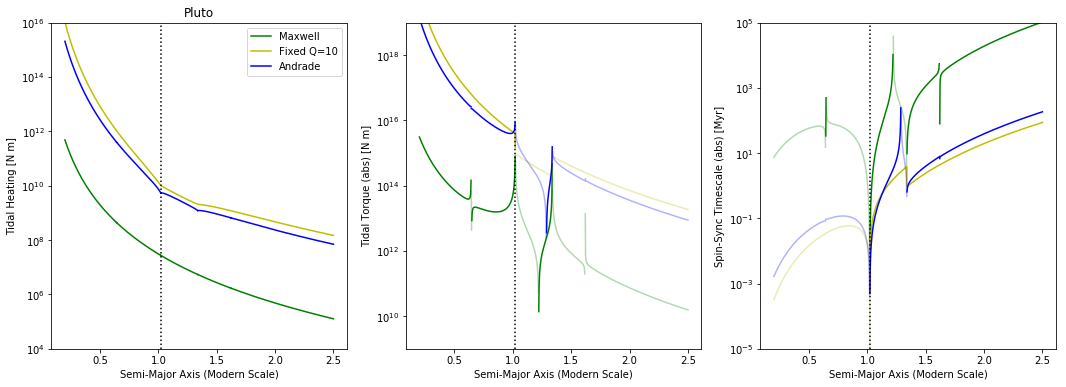

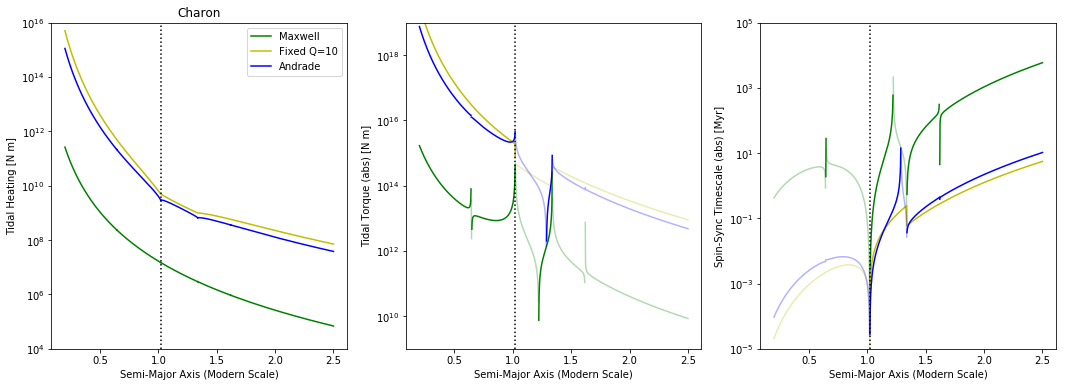

In [47]:
print('Plot Set 1 - Individual Evolution')
print('Light colors in the plots indicate negative values.')
for obj_lookup, spin_freq in [(host_byrheo, spin_frequency_host), (planet_byrheo, spin_frequency_planet)]:

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    title_set = False
    axes[0].set_xlabel('Semi-Major Axis (Modern Scale)')
    axes[1].set_xlabel('Semi-Major Axis (Modern Scale)')
    axes[2].set_xlabel('Semi-Major Axis (Modern Scale)')
    axes[0].set_yscale('log')
    axes[1].set_yscale('log')
    axes[2].set_yscale('log')
    axes[0].set_ylabel('Tidal Heating [N m]')
    axes[1].set_ylabel('Tidal Torque (abs) [N m]')
    axes[2].set_ylabel('Spin-Sync Timescale (abs) [Myr]')
    axes[0].set_ylim((1e4, 1e16))
    axes[1].set_ylim((1e9, 1e19))
    axes[2].set_ylim((1e-5, 1e5))

    for rheo_name, rheo_color in rheo_data:

        obj = obj_lookup[rheo_name]
        orbit = orbits_byrheo[rheo_name]
        if not title_set:
            axes[0].set_title(obj.name.title())

        # Pull out tide info
        tidal_heating = obj.tidal_heating
        tidal_torque = obj.tidal_ztorque
        spin_derivative = obj.derivative_spin
        tau_spin = sec2myr(-np.abs(obj.spin_freq - orbit.get_orbital_freq(obj)) / spin_derivative)

        # Make two tidal torques for log-scale plotting of negative numbers
        tidal_torque_pos, tidal_torque_neg = neg_array_for_log_plot(tidal_torque)

        # Likewise for tau_spin
        tau_spin_pos, tau_spin_neg = neg_array_for_log_plot(tau_spin)

        axes[0].plot(semi_major_axis_scale, tidal_heating, c=rheo_color, label=rheo_name)

        axes[1].plot(semi_major_axis_scale, tidal_torque_pos, c=rheo_color)
        axes[1].plot(semi_major_axis_scale, tidal_torque_neg, c=rheo_color, alpha=0.3)

        axes[2].plot(semi_major_axis_scale, tau_spin_pos, c=rheo_color)
        axes[2].plot(semi_major_axis_scale, tau_spin_neg, c=rheo_color, alpha=0.3)

    spin_sync_semi_a_au = orbital_motion2semi_a(spin_freq, host.mass, planet.mass) / modern_semi_major_axis
    axes[0].axvline(x=spin_sync_semi_a_au, c='k', ls=':')
    axes[1].axvline(x=spin_sync_semi_a_au, c='k', ls=':')
    axes[2].axvline(x=spin_sync_semi_a_au, c='k', ls=':')
    axes[0].legend(loc='best')

plt.show()

## Plot Set 2


Plot Set 2 - Orbital Evolution
Light colors in the plots indicate negative values.


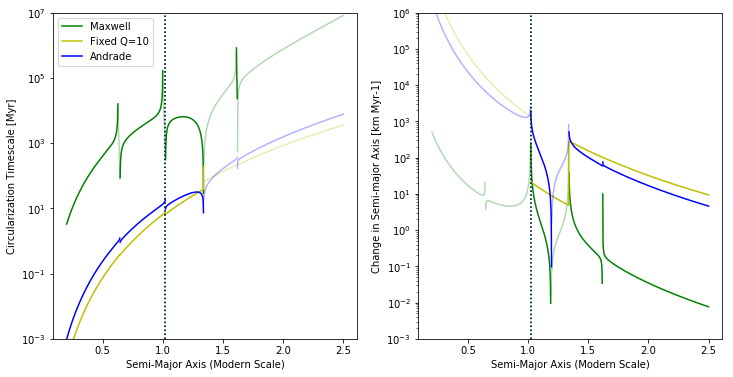

In [48]:
# Plot Set 2
print('Plot Set 2 - Orbital Evolution')
print('Light colors in the plots indicate negative values.')
fig2, axes2 = plt.subplots(1, 2, figsize=(12, 6))
axes2[0].set_xlabel('Semi-Major Axis (Modern Scale)')
axes2[1].set_xlabel('Semi-Major Axis (Modern Scale)')
axes2[0].set_yscale('log')
axes2[1].set_yscale('log')
axes2[0].set_ylabel('Circularization Timescale [Myr]')
axes2[1].set_ylabel('Change in Semi-major Axis [km Myr-1]')
axes2[0].set_ylim((1e-3, 1e7))
axes2[1].set_ylim((1e-3, 1e6))

for rheo_name, rheo_color in rheo_data:
    planet_ = planet_byrheo[rheo_name]
    host_ = host_byrheo[rheo_name]
    orbit_ = orbits_byrheo[rheo_name]

    # The evolution of eccentricity and semi-major axis is the same for both the host and the target planet. So we can use
    #    either as the reference.
    ref_obj = host_
    de_dt = orbit_.get_derivative_eccentricity(ref_obj)
    da_dt = orbit_.get_derivative_semi_major(ref_obj)

    # Get timescales for de_dt
    tau_e = -(eccen / de_dt)
    tau_e = sec2myr(tau_e)

    # Convert units on semi-major axis [m s-1] to [km myr-1]
    da_dt = da_dt * (3.154e13 / 1000.)

    # Make both positive for log plotting
    tau_e_pos, tau_e_neg = neg_array_for_log_plot(tau_e)
    da_dt_pos, da_dt_neg = neg_array_for_log_plot(da_dt)

    axes2[0].plot(semi_major_axis_scale, tau_e_pos, c=rheo_color, label=rheo_name)
    axes2[0].plot(semi_major_axis_scale, tau_e_neg, c=rheo_color, alpha=0.3)

    axes2[1].plot(semi_major_axis_scale, da_dt_pos, c=rheo_color)
    axes2[1].plot(semi_major_axis_scale, da_dt_neg, c=rheo_color, alpha=0.3)

spin_sync_semi_a_au = orbital_motion2semi_a(spin_frequency_planet, host.mass, planet.mass) / modern_semi_major_axis
axes2[0].axvline(x=spin_sync_semi_a_au, c='c', ls=':')
axes2[1].axvline(x=spin_sync_semi_a_au, c='c', ls=':')
spin_sync_semi_a_au = orbital_motion2semi_a(spin_frequency_host, host.mass, planet.mass) / modern_semi_major_axis
axes2[0].axvline(x=spin_sync_semi_a_au, c='k', ls=':')
axes2[1].axvline(x=spin_sync_semi_a_au, c='k', ls=':')
axes2[0].legend(loc='best')

plt.show()